# Library Import

In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.Path().resolve().parent))

#-- Basics Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import joblib
from sklearn.preprocessing import MinMaxScaler


#-- Metrics Calculation
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_percentage_error as MAPE

#-- Warnings OFF
from warnings import simplefilter

from utils import *
from narmax import *


pd.set_option('display.max_columns', None)
simplefilter("ignore", FutureWarning)
np.seterr(all="ignore")
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['PYTHONHASHSEED']=str('123')

%matplotlib inline

2025-11-06 10:03:20.454845: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-06 10:03:24.479767: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-06 10:03:32.814021: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


# Param definition

In [2]:
def model_performance(df_predicted):
    train = df_predicted[df_predicted.tipo == '1. train']
    validation = df_predicted[df_predicted.tipo == '2. validation']
    test = df_predicted[df_predicted.tipo == '3. test']

    metric_df_final = pd.DataFrame(
        {
        'sample': df_predicted['sample'].unique()[0],
        'tipo':['Treino','Validation','Teste'],
        'MSE': [MSE(train['real'],train['pred']), MSE(validation['real'],validation['pred']), MSE(test['real'],test['pred'])],
        'MAE': [MAE(train['real'],train['pred']), MAE(validation['real'],validation['pred']), MAE(test['real'],test['pred'])],
        'MAPE': [MAPE(train['real'],train['pred']), MAPE(validation['real'],validation['pred']), MAPE(test['real'],test['pred'])],
        'R2':  [R2(train['real'],train['pred']), R2(validation['real'],validation['pred']), R2(test['real'],test['pred'])],
        }
    )

    return metric_df_final

def model_performance_vec(df_predicted):

    mean_precition = df_predicted.groupby('date').agg({'sample':'mean','real':'mean','predicted_value':['mean','std','min','max','count']})
    mean_precition.reset_index(inplace=True)
    mean_precition.columns = ['date','sample','real','mean','std','min','max','count']
    mean_precition['date'] = pd.to_datetime(mean_precition['date'])
    mean_precition['tipo'] = mean_precition['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))


    train = mean_precition[mean_precition.tipo == '1. train']
    validation = mean_precition[mean_precition.tipo == '2. validation']
    test = mean_precition[mean_precition.tipo == '3. test']

    metric_df_final = pd.DataFrame(
        {
        'sample': mean_precition['sample'].unique()[0],
        'tipo':['Treino','Validation','Teste'],
        'MSE': [MSE(train['real'],train['mean']), MSE(validation['real'],validation['mean']), MSE(test['real'],test['mean'])],
        'MAE': [MAE(train['real'],train['mean']), MAE(validation['real'],validation['mean']), MAE(test['real'],test['mean'])],
        'MAPE': [MAPE(train['real'],train['mean']), MAPE(validation['real'],validation['mean']), MAPE(test['real'],test['mean'])],
        'R2':  [R2(train['real'],train['mean']), R2(validation['real'],validation['mean']), R2(test['real'],test['mean'])],
        }
    )

    return metric_df_final

In [3]:
#-- Parameters
look_back = 12
num_month = 12
vec_num = 12

#-- Training and fitting
epochs=1000
batch_size= 120

FIGURE_PATH = '../Figure/Results/'

# Camargos

In [ ]:
camargos_raw = pd.read_csv(f'../Datasets/Processed/Camargos.csv')
esc_camargos = escalar_narmax_build(camargos_raw,look_back=12)
vec_camargos = vetorial_narmax_build(camargos_raw,look_back=12)

In [ ]:
vec_camargos

In [ ]:
esc_camargos.groupby('cohort').agg(
    {'date':['min','max','count']
    }
)


In [ ]:
vec_camargos.groupby('cohort').agg(
    {'start_date':['min','max','count'],
     'end_date':['min','max','count']
    }
)


## Escalar 

In [ ]:
lag_list = [x for x in esc_camargos.columns if 'lag' in x]
pred_list = ['pred_1']

In [ ]:
esc_train = esc_camargos[esc_camargos['cohort'] == '1. train'].copy()
esc_validation = esc_camargos[esc_camargos['cohort'] == '2. validation'].copy()
esc_test = esc_camargos[esc_camargos['cohort'] == '3. test'].copy()

In [ ]:
file_path = "../Results/Models/camargos_esc_weights_narmax_img.weights.h5"

# Definindo os callbacks

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=100,
#     verbose=0,
#     mode='min',
#     start_from_epoch=200,
#     restore_best_weights=True
# )

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=10,
#     min_lr=1e-4,
#     verbose=0,
#     mode='min'
# )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0
)


In [ ]:
model_esc = NarmaxModel(look_back=12,vec_num=1)

callbacks_list = [
    model_checkpoint
    ]

history = model_esc.fit(
    esc_train[lag_list],
    esc_train[pred_list],
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(esc_validation[lag_list], esc_validation[pred_list]),
    callbacks=callbacks_list,
    shuffle=True
)


In [ ]:
# Plot and save loss function from model history

method_name = 'NARMAX ESCALAR - CAMARGOS'
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss - {method_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(f'{FIGURE_PATH}/model_loss_{method_name}.png', format='png')
plt.show()



In [ ]:
# model_esc_camargos = NarmaxModel(look_back=12, vec_num=1)
# model_esc_camargos.load_weights(file_path)
camargos_scaler = joblib.load('../Results/Models/Camargos_scaler.pkl')

df_escalar = esc_camargos[['date','pred_1']].copy()
df_escalar.columns = ['date','real_norm']
df_escalar['real'] = camargos_scaler.inverse_transform(df_escalar[['real_norm']])
# df_escalar['pred_norm'] = model_esc_camargos.predict(esc_camargos[lag_list])
# df_escalar['pred'] = camargos_scaler.inverse_transform(df_escalar[['pred_norm']])
# df_escalar['tipo'] = df_escalar['date'].apply(lambda x: cohort_type(x,model_type='escalar'))

# df_escalar.to_csv('../Results/NARMAX/Camargos/Escalar/narmax_camargos_pred_2025_10_08.csv', index=False)

# df_escalar


In [ ]:
# train = df_escalar[df_escalar.tipo == '1. train']
# validation = df_escalar[df_escalar.tipo == '2. validation']
# test = df_escalar[df_escalar.tipo == '3. test']

# metric_df_final = pd.DataFrame(
#       {
#       'tipo':['Treino','Validation','Teste'],
#       'MSE': [MSE(train['real'],train['pred']), MSE(validation['real'],validation['pred']), MSE(test['real'],test['pred'])],
#       'MAE': [MAE(train['real'],train['pred']), MAE(validation['real'],validation['pred']), MAE(test['real'],test['pred'])],
#       'MAPE': [MAPE(train['real'],train['pred']), MAPE(validation['real'],validation['pred']), MAPE(test['real'],test['pred'])],
#       'R2':  [R2(train['real'],train['pred']), R2(validation['real'],validation['pred']), R2(test['real'],test['pred'])],
#       }
#   )
# display(metric_df_final)
# metric_df_final.to_csv('../Results/NARMAX/Camargos/Escalar/narmax_camargos_metrics_2025_10_08.csv' , index=False)

In [ ]:
# figure, axes = plt.subplots(2, 1, figsize=(16,6))
# figure.suptitle(f'R2 Plot - Problema Escalar - Camargos')

# r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

# min = test['real'].min()
# max = test['real'].max()
# axes[0].set_title(f'$R^2$ - NARMAX R2: {r2_result:.2f}') #r2_result:.3f}')
# axes[0].scatter(test['real'], test['pred'])
# axes[0].plot([min, max], [min, max], 'k--', lw=2)
# axes[0].set_xlabel('Real')
# axes[0].set_ylabel('Previsto')

# sns.lineplot(ax = axes[1], data=test,x='date',y='real', label='Real')
# sns.lineplot(ax = axes[1], data=test,x='date',y='pred', label='Previsto')
# axes[1].set_xlabel('Tempo')
# axes[1].set_ylabel('Vazão [$m^3$/s]')

# plt.savefig(f'../Figure/Results/narmax_esc_camargos_r2_2025_10_08.png', format='png')

# plt.show()

In [ ]:
sample = 100

# metrics_list = []
# for i in range(sample):
#     model_temp = NarmaxModel(look_back=12,vec_num=1)

#     file_path = f"../Results/Models/camargos_esc_weights_narmax_sample_{i}.weights.h5"

#     model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#         filepath=file_path,
#         save_weights_only=True,
#         monitor='val_loss',
#         mode='min',
#         save_best_only=True,
#         verbose=0
#     )

#     model_temp.fit(
#         esc_train[lag_list],
#         esc_train[pred_list],
#         epochs=epochs,
#         batch_size=batch_size,
#         verbose=0,
#         validation_data=(esc_validation[lag_list], esc_validation[pred_list]),
#         # callbacks=[model_checkpoint],
#         shuffle=True
#     )

#     model_esc_camargos = model_temp
#     camargos_scaler = joblib.load('../Results/Models/camargos_scaler.pkl')

#     df_escalar = esc_camargos[['date','pred_1']].copy()
#     df_escalar.columns = ['date','real_norm']
#     df_escalar['real'] = camargos_scaler.inverse_transform(df_escalar[['real_norm']])
#     df_escalar['pred_norm'] = model_esc_camargos.predict(esc_camargos[lag_list])
#     df_escalar['pred'] = camargos_scaler.inverse_transform(df_escalar[['pred_norm']])
#     df_escalar['tipo'] = df_escalar['date'].apply(lambda x: cohort_type(x,model_type='escalar'))
#     df_escalar['sample'] = i
#     print(i)

#     df_escalar.to_csv(f'../Results/NARMAX/Camargos/Escalar/Samples/narmax_camargos_pred_sample_{i}.csv', index=False)




In [ ]:
def model_performance(df_predicted):
    train = df_predicted[df_predicted.tipo == '1. train']
    validation = df_predicted[df_predicted.tipo == '2. validation']
    test = df_predicted[df_predicted.tipo == '3. test']

    metric_df_final = pd.DataFrame(
        {
        'sample': df_predicted['sample'].unique()[0],
        'tipo':['Treino','Validation','Teste'],
        'MSE': [MSE(train['real'],train['pred']), MSE(validation['real'],validation['pred']), MSE(test['real'],test['pred'])],
        'MAE': [MAE(train['real'],train['pred']), MAE(validation['real'],validation['pred']), MAE(test['real'],test['pred'])],
        'MAPE': [MAPE(train['real'],train['pred']), MAPE(validation['real'],validation['pred']), MAPE(test['real'],test['pred'])],
        'R2':  [R2(train['real'],train['pred']), R2(validation['real'],validation['pred']), R2(test['real'],test['pred'])],
        }
    )
    # display(metric_df_final)

    return metric_df_final



In [ ]:
all_results = pd.concat([model_performance(pd.read_csv(f'../Results/NARMAX/Camargos/Escalar/Samples/narmax_camargos_pred_sample_{i}.csv')) for i in range(sample)]).reset_index(drop=True)
all_results.to_csv(f'../Results/NARMAX/Camargos/Escalar/Samples/all_results.csv', index=False)
all_results

## Vetorial

In [ ]:
lag_list = [x for x in vec_camargos.columns if 'lag' in x]
pred_list = [x for x in vec_camargos.columns if 'pred' in x]


vec_train = vec_camargos[vec_camargos['cohort'] == '1. train'].copy()
vec_validation = vec_camargos[vec_camargos['cohort'] == '2. validation'].copy()
vec_test = vec_camargos[vec_camargos['cohort'] == '3. test'].copy()

In [ ]:
print(vec_train.shape)
print(vec_validation.shape)
print(vec_test.shape)


In [ ]:
# only_one_year = [str(x) +'-01-01' for x in range(1932,2012 + 1,1)]
# reduced_vec_camargos = vec_camargos[vec_camargos['date'].isin(only_one_year)]
# vec_train = reduced_vec_camargos[reduced_vec_camargos['cohort'] == '1. train'].copy()
# vec_validation = reduced_vec_camargos[reduced_vec_camargos['cohort'] == '2. validation'].copy()
# vec_test = reduced_vec_camargos[reduced_vec_camargos['cohort'] == '3. test'].copy()
# print(vec_train.shape)
# print(vec_validation.shape)
# print(vec_test.shape)


In [ ]:
model_vec = NarmaxModel(look_back=12,vec_num=12)
file_path = f"../Results/Models/camargos_vec_weights_narmax_img.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0
)

history = model_vec.fit(
    vec_train[lag_list],
    vec_train[pred_list],
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(vec_validation[lag_list], vec_validation[pred_list]),
    # callbacks=[model_checkpoint],
    shuffle=True
)

# Plot and save loss function from model history

method_name = 'NARMAX_VETORIAL'
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss - {method_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
# plt.savefig(f'{FIGURE_PATH}/model_loss_{method_name}.png', format='png')
plt.show()


In [ ]:
# model_vec_camargos_final = NarmaxModel(look_back=12, vec_num=12)
# model_vec_camargos_final.load_weights(file_path)

model_vec_camargos_final = model_vec

df_vec = vec_camargos[[x for x in vec_camargos.columns if 'lag' not in x]].copy()


df_vec.columns = [x.replace('pred_','real_') for x in df_vec.columns]

df_vec[pred_list] = pd.DataFrame(model_vec_camargos_final.predict(vec_camargos[lag_list]),columns=pred_list)
df_vec.to_csv('../Results/NARMAX/Camargos/Vetorial/narmax_camargos_pred_2025_10_09.csv', index=False)

df_vec

In [ ]:
df_vec_pred = df_escalar[['date', 'real_norm', 'real']].copy()
all_list = []
for i in range(12):
    df_temp = df_vec.copy()
    df_temp['predicted_date'] = (df_temp['end_date'] - pd.Timedelta(weeks=4*(i))).dt.strftime('%Y-%m-01')
    df_temp['predicted_value_norm'] = df_temp[f'pred_{str(12 - i)}']
    df_temp['predicted_value'] = camargos_scaler.inverse_transform(df_temp[['predicted_value_norm']])
    df_temp['index'] = df_temp.index
    
    df_temp = df_temp[['predicted_date','predicted_value_norm','predicted_value','index']]
    all_list.append(df_temp)

all_list = pd.concat(all_list,axis=0,ignore_index=True)
all_list['date'] = pd.to_datetime(all_list['predicted_date'])
all_list['cohort'] = all_list['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))

df_vec_all = df_vec_pred.merge(all_list,on='date',how='left')
df_vec_all.to_csv('../Results/NARMAX/Camargos/Vetorial/narmax_camargos_pred_all_2025_10_09.csv', index=False)
df_vec_all


In [ ]:
mean_precition = df_vec_all.groupby('date').agg({'real':'mean','predicted_value':['mean','std','min','max','count']})
mean_precition.reset_index(inplace=True)
mean_precition.columns = ['date','real','mean','std','min','max','count']
mean_precition['date'] = pd.to_datetime(mean_precition['date'])
mean_precition['cohort'] = mean_precition['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))
mean_precition.to_csv('../Results/NARMAX/Camargos/Vetorial/narmax_camargos_pred_all_mean_2025_10_09.csv', index=False)

mean_precition.head(15)

In [ ]:
# train = df_vec[df_vec.cohort == '1. train']
# validation = df_vec[df_vec.cohort == '2. validation']
# test = df_vec[df_vec.cohort == '3. test']

train = mean_precition[mean_precition.cohort == '1. train']
validation = mean_precition[mean_precition.cohort == '2. validation']
test = mean_precition[mean_precition.cohort == '3. test']


In [ ]:


metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Validation','Teste'],
      'MSE': [MSE(train['real'],train['mean']), MSE(validation['real'],validation['mean']), MSE(test['real'],test['mean'])],
      'MAE': [MAE(train['real'],train['mean']), MAE(validation['real'],validation['mean']), MAE(test['real'],test['mean'])],
      'MAPE': [MAPE(train['real'],train['mean']), MAPE(validation['real'],validation['mean']), MAPE(test['real'],test['mean'])],
      'R2':  [R2(train['real'],train['mean']), R2(validation['real'],validation['mean']), R2(test['real'],test['mean'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('../Results/NARMAX/Camargos/Vetorial/narmax_camargos_metrics_2025_10_14.csv' , index=False)

In [ ]:
df_vec_all.head()

In [ ]:
figure, axes = plt.subplots(2, 1, figsize=(16,6))
#figure.suptitle(f'R2 Plot - Scalar problem')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]
min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - NARMAX R2: {r2_result:.2f}') #r2_result:.3f}')
# axes[0].scatter(test['real'], test['mean'])
axes[0].scatter(test['real'], test['mean'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=test,x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=test,x='date',y='mean', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

# plt.savefig(f'../Figure/Results/narmax_vec_camargos_r2_2025_10_08.png', format='png')


plt.show()

In [ ]:
sample = 100

metrics_list = []
for s in range(sample):
    model_temp = NarmaxModel(look_back=12,vec_num=12)

    file_path = f"../Results/Models/camargos_vec_weights_narmax_sample_{i}.weights.h5"

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=file_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0
    )

    model_temp.fit(
        vec_train[lag_list],
        vec_train[pred_list],
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        validation_data=(vec_validation[lag_list], vec_validation[pred_list]),
        callbacks=[model_checkpoint],
        shuffle=True
    )

    model_vec_camargos = NarmaxModel(look_back=12, vec_num=12)
    model_vec_camargos.load_weights(file_path)
    camargos_scaler = joblib.load('../Results/Models/Camargos_scaler.pkl')

    df_vec = vec_camargos[[x for x in vec_camargos.columns if 'lag' not in x]].copy()
    df_vec.columns = [x.replace('pred_','real_') for x in df_vec.columns]
    df_vec[pred_list] = pd.DataFrame(model_vec_camargos.predict(vec_camargos[lag_list]),columns=pred_list)
    df_vec['sample'] = s

    print(s)
    df_vec.to_csv(f'../Results/NARMAX/Camargos/Vetorial/Samples/narmax_camargos_pred_sample_{i}.csv', index=False)

    df_vec_pred = df_escalar[['date', 'real_norm', 'real']].copy()
    all_list = []
    for i in range(12):
        df_temp = df_vec.copy()
        df_temp['predicted_date'] = (df_temp['end_date'] - pd.Timedelta(weeks=4*(i))).dt.strftime('%Y-%m-01')
        df_temp['predicted_value_norm'] = df_temp[f'pred_{str(12 - i)}']
        df_temp['predicted_value'] = camargos_scaler.inverse_transform(df_temp[['predicted_value_norm']])
        df_temp['index'] = df_temp.index
        
        df_temp = df_temp[['predicted_date','predicted_value_norm','predicted_value','index']]
        all_list.append(df_temp)

    all_list = pd.concat(all_list,axis=0,ignore_index=True)
    all_list['date'] = pd.to_datetime(all_list['predicted_date'])
    all_list['cohort'] = all_list['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))
    all_list['sample'] = s

    df_vec_all = df_vec_pred.merge(all_list,on='date',how='left')
    df_vec_all.to_csv(f'../Results/NARMAX/Camargos/Vetorial/Samples/narmax_camargos_pred_all_sample_{s}.csv', index=False)

    



In [ ]:


all_results = pd.concat([model_performance_vec(pd.read_csv(f'../Results/NARMAX/Camargos/Vetorial/Samples/narmax_camargos_pred_all_sample_{i}.csv')) for i in range(sample)]).reset_index(drop=True)
all_results.to_csv(f'../Results/NARMAX/Camargos/Vetorial/Samples/all_results.csv', index=False)
all_results



In [ ]:
# plt.savefig(f'../Figure/Results/narmax_camargos_r2_2025_10_08.png', format='png')


plt.show()

# Furnas

In [4]:
furnas_raw = pd.read_csv(f'../Datasets/Processed/Furnas.csv')
esc_furnas = escalar_narmax_build(furnas_raw,look_back=12)
vec_furnas = vetorial_narmax_build(furnas_raw,look_back=12)

In [5]:
vec_furnas

,date,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,start_date,end_date,cohort
0,1931-01-01,0.358007,0.776808,0.552491,0.388686,0.295525,0.163524,0.113425,0.074585,0.094005,0.128905,0.130312,0.259780,0.479595,0.476780,0.374332,0.186884,0.132001,0.120462,0.075711,0.053194,0.051787,0.089220,0.103856,0.357444,1932-01-01,1932-12-01,1. train
1,1931-02-01,0.776808,0.552491,0.388686,0.295525,0.163524,0.113425,0.074585,0.094005,0.128905,0.130312,0.259780,0.479595,0.476780,0.374332,0.186884,0.132001,0.120462,0.075711,0.053194,0.051787,0.089220,0.103856,0.357444,0.316915,1932-02-01,1933-01-01,1. train
2,1931-03-01,0.552491,0.388686,0.295525,0.163524,0.113425,0.074585,0.094005,0.128905,0.130312,0.259780,0.479595,0.476780,0.374332,0.186884,0.132001,0.120462,0.075711,0.053194,0.051787,0.089220,0.103856,0.357444,0.316915,0.146918,1932-03-01,1933-02-01,1. train
3,1931-04-01,0.388686,0.295525,0.163524,0.113425,0.074585,0.094005,0.128905,0.130312,0.259780,0.479595,0.476780,0.374332,0.186884,0.132001,0.120462,0.075711,0.053194,0.051787,0.089220,0.103856,0.357444,0.316915,0.146918,0.138475,1932-04-01,1933-03-01,1. train
4,1931-05-01,0.295525,0.163524,0.113425,0.074585,0.094005,0.128905,0.130312,0.259780,0.479595,0.476780,0.374332,0.186884,0.132001,0.120462,0.075711,0.053194,0.051787,0.089220,0.103856,0.357444,0.316915,0.146918,0.138475,0.114270,1932-05-01,1933-04-01,1. train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,2010-09-01,0.022516,0.070645,0.184914,0.368140,0.775401,0.248522,0.486068,0.241768,0.139037,0.119336,0.079932,0.051787,0.026457,0.071770,0.087532,0.406417,0.682240,0.287363,0.198705,0.146355,0.132564,0.150858,0.085561,0.038278,2011-09-01,2012-08-01,3. test
957,2010-10-01,0.070645,0.184914,0.368140,0.775401,0.248522,0.486068,0.241768,0.139037,0.119336,0.079932,0.051787,0.026457,0.071770,0.087532,0.406417,0.682240,0.287363,0.198705,0.146355,0.132564,0.150858,0.085561,0.038278,0.016324,2011-10-01,2012-09-01,3. test
958,2010-11-01,0.184914,0.368140,0.775401,0.248522,0.486068,0.241768,0.139037,0.119336,0.079932,0.051787,0.026457,0.071770,0.087532,0.406417,0.682240,0.287363,0.198705,0.146355,0.132564,0.150858,0.085561,0.038278,0.016324,0.013791,2011-11-01,2012-10-01,3. test
959,2010-12-01,0.368140,0.775401,0.248522,0.486068,0.241768,0.139037,0.119336,0.079932,0.051787,0.026457,0.071770,0.087532,0.406417,0.682240,0.287363,0.198705,0.146355,0.132564,0.150858,0.085561,0.038278,0.016324,0.013791,0.065015,2011-12-01,2012-11-01,3. test


In [6]:
esc_furnas.groupby('cohort').agg(
    {'date':['min','max','count']
    }
)


date                 
                     min        max count
cohort                                   
1. train      1932-01-01 1997-11-01   791
2. validation 1997-12-01 2002-12-01    61
3. test       2003-01-01 2012-12-01   120

In [7]:
vec_furnas.groupby('cohort').agg(
    {'start_date':['min','max','count'],
     'end_date':['min','max','count']
    }
)


start_date                    end_date                 
                     min        max count        min        max count
cohort                                                               
1. train      1932-01-01 1996-12-01   780 1932-12-01 1997-11-01   780
2. validation 1997-01-01 2002-01-01    61 1997-12-01 2002-12-01    61
3. test       2002-02-01 2012-01-01   120 2003-01-01 2012-12-01   120

In [8]:
model_esc = NarmaxModel(look_back=12,vec_num=1)
model_vec = NarmaxModel(look_back=12,vec_num=12)

2025-11-06 10:03:36.154553: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Escalar 

In [9]:
lag_list = [x for x in esc_furnas.columns if 'lag' in x]
pred_list = ['pred_1']

In [10]:
esc_train = esc_furnas[esc_furnas['cohort'] == '1. train'].copy()
esc_validation = esc_furnas[esc_furnas['cohort'] == '2. validation'].copy()
esc_test = esc_furnas[esc_furnas['cohort'] == '3. test'].copy()

In [11]:
file_path = "../Results/Models/furnas_esc_weights_narmax_img.weights.h5"

# Definindo os callbacks

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=100,
#     verbose=0,
#     mode='min',
#     start_from_epoch=200,
#     restore_best_weights=True
# )

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=10,
#     min_lr=1e-4,
#     verbose=0,
#     mode='min'
# )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0
)


In [12]:
callbacks_list = [
    model_checkpoint
    ]

history = model_esc.fit(
    esc_train[lag_list],
    esc_train[pred_list],
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(esc_validation[lag_list], esc_validation[pred_list]),
    callbacks=callbacks_list,
    shuffle=True
)


Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0840 - mae: 0.2323 - mape: 16464.8457 - mse: 0.0840 - val_loss: 0.0380 - val_mae: 0.1470 - val_mape: 141.7132 - val_mse: 0.0380
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0728 - mae: 0.2078 - mape: 6502.7168 - mse: 0.0728 - val_loss: 0.0340 - val_mae: 0.1319 - val_mape: 85.9513 - val_mse: 0.0340
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0668 - mae: 0.1924 - mape: 24897.2344 - mse: 0.0668 - val_loss: 0.0317 - val_mae: 0.1232 - val_mape: 102.6272 - val_mse: 0.0317
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0631 - mae: 0.1820 - mape: 33249.2422 - mse: 0.0631 - val_loss: 0.0297 - val_mae: 0.1170 - val_mape: 114.7773 - val_mse: 0.0297
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0599 - mae: 0.1736 - mape: 44873.9531 - mse: 0.0599 - val_loss: 0.0278 - val_mae: 0.1115 - val_mape: 128.2653 - val_mse: 0.0278
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss

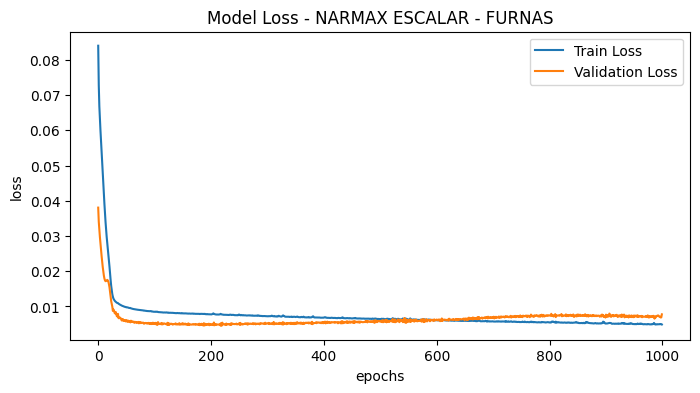

In [13]:
# Plot and save loss function from model history

method_name = 'NARMAX ESCALAR - FURNAS'
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss - {method_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(f'{FIGURE_PATH}/model_loss_{method_name}.png', format='png')
plt.show()



In [14]:
model_esc_furnas = NarmaxModel(look_back=12, vec_num=1)
model_esc_furnas.load_weights(file_path)
furnas_scaler = joblib.load('../Results/Models/Furnas_scaler.pkl')


df_escalar = esc_furnas[['date','pred_1']].copy()
df_escalar.columns = ['date','real_norm']
df_escalar['real'] = furnas_scaler.inverse_transform(df_escalar[['real_norm']])
df_escalar['pred_norm'] = model_esc_furnas.predict(esc_furnas[lag_list])

df_escalar['pred'] = furnas_scaler.inverse_transform(df_escalar[['pred_norm']])
df_escalar['tipo'] = df_escalar['date'].apply(lambda x: cohort_type(x,model_type='escalar'))

df_escalar.to_csv('../Results/NARMAX/Furnas/Escalar/narmax_furnas_pred_2025_10_15.csv', index=False)

df_escalar


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/thiago-lopes/anaconda3/envs/e-tuni-ita/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


,date,real_norm,real,pred_norm,pred,tipo
0,1932-01-01,0.479595,1908.0,0.419893,1695.880371,1. train
1,1932-02-01,0.476780,1898.0,0.529136,2084.020508,1. train
2,1932-03-01,0.374332,1534.0,0.446745,1791.285767,1. train
3,1932-04-01,0.186884,868.0,0.224714,1002.409790,1. train
4,1932-05-01,0.132001,673.0,0.138974,697.773987,1. train
...,...,...,...,...,...,...
967,2012-08-01,0.038278,340.0,0.060936,420.505280,3. test
968,2012-09-01,0.016324,262.0,0.093929,537.730286,3. test
969,2012-10-01,0.013791,253.0,0.074650,469.232819,3. test
970,2012-11-01,0.065015,435.0,0.088434,518.205017,3. test


In [15]:
train = df_escalar[df_escalar.tipo == '1. train']
validation = df_escalar[df_escalar.tipo == '2. validation']
test = df_escalar[df_escalar.tipo == '3. test']

metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Validation','Teste'],
      'MSE': [MSE(train['real'],train['pred']), MSE(validation['real'],validation['pred']), MSE(test['real'],test['pred'])],
      'MAE': [MAE(train['real'],train['pred']), MAE(validation['real'],validation['pred']), MAE(test['real'],test['pred'])],
      'MAPE': [MAPE(train['real'],train['pred']), MAPE(validation['real'],validation['pred']), MAPE(test['real'],test['pred'])],
      'R2':  [R2(train['real'],train['pred']), R2(validation['real'],validation['pred']), R2(test['real'],test['pred'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('../Results/NARMAX/Furnas/Escalar/narmax_furnas_metrics_2025_10_15.csv' , index=False)

,tipo,MSE,MAE,MAPE,R2
0,Treino,97373.849935,194.830630,0.197428,0.746859
1,Validation,57146.943288,157.941228,0.230353,0.738747
2,Teste,118977.635430,211.154869,0.232736,0.682092


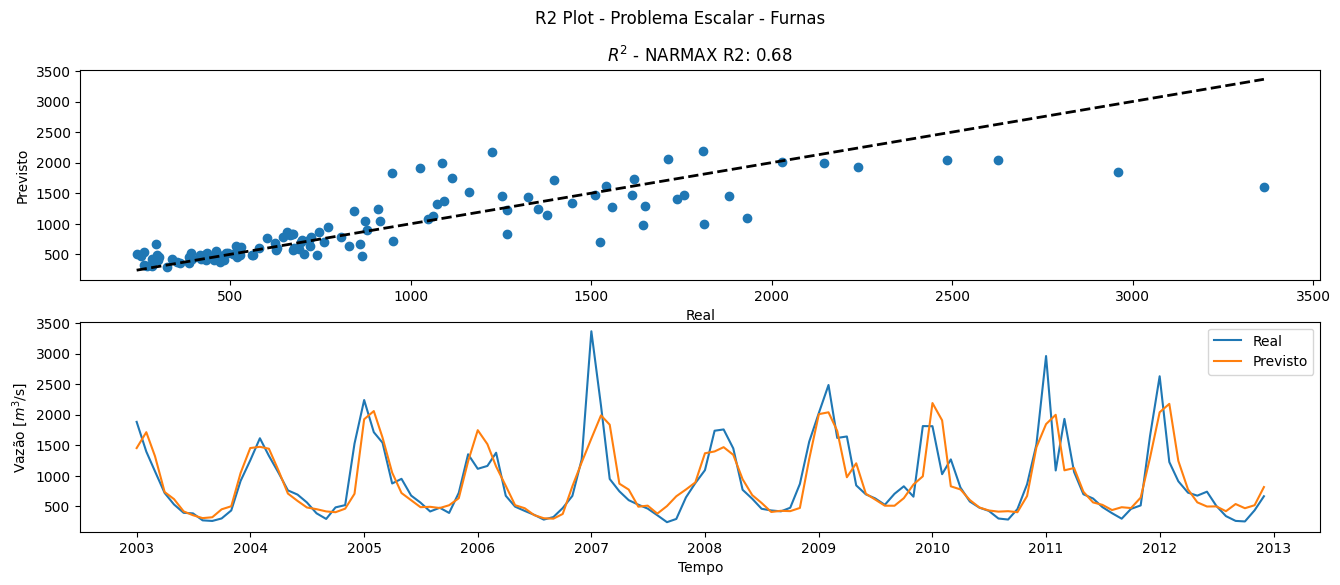

In [16]:
figure, axes = plt.subplots(2, 1, figsize=(16,6))
figure.suptitle(f'R2 Plot - Problema Escalar - Furnas')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]

min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - NARMAX R2: {r2_result:.2f}') #r2_result:.3f}')
axes[0].scatter(test['real'], test['pred'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Real')
axes[0].set_ylabel('Previsto')

sns.lineplot(ax = axes[1], data=test,x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=test,x='date',y='pred', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'../Figure/Results/narmax_esc_furnas_r2_2025_10_15.png', format='png')

plt.show()

In [17]:
sample = 100

# metrics_list = []
# for i in range(sample):
#     model_temp = NarmaxModel(look_back=12,vec_num=1)

#     file_path = f"../Results/Models/furnas_esc_weights_narmax_sample_{i}.weights.h5"

#     model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#         filepath=file_path,
#         save_weights_only=True,
#         monitor='val_loss',
#         mode='min',
#         save_best_only=True,
#         verbose=0
#     )

#     model_temp.fit(
#         esc_train[lag_list],
#         esc_train[pred_list],
#         epochs=epochs,
#         batch_size=batch_size,
#         verbose=0,
#         validation_data=(esc_validation[lag_list], esc_validation[pred_list]),
#         callbacks=[model_checkpoint],
#         shuffle=True
#     )

#     model_esc_furnas = NarmaxModel(look_back=12, vec_num=1)
#     model_esc_furnas.load_weights(file_path)
#     furnas_scaler = joblib.load('../Results/Models/furnas_scaler.pkl')

#     df_escalar = esc_furnas[['date','pred_1']].copy()
#     df_escalar.columns = ['date','real_norm']
#     df_escalar['real'] = furnas_scaler.inverse_transform(df_escalar[['real_norm']])
#     df_escalar['pred_norm'] = model_esc_furnas.predict(esc_furnas[lag_list])
#     df_escalar['pred'] = furnas_scaler.inverse_transform(df_escalar[['pred_norm']])
#     df_escalar['tipo'] = df_escalar['date'].apply(lambda x: cohort_type(x,model_type='escalar'))
#     df_escalar['sample'] = i
#     print(i)

#     df_escalar.to_csv(f'../Results/NARMAX/Furnas/Escalar/Samples/narmax_furnas_pred_sample_{i}.csv', index=False)




In [18]:
all_results = pd.concat([model_performance(pd.read_csv(f'../Results/NARMAX/Furnas/Escalar/Samples/narmax_furnas_pred_sample_{i}.csv')) for i in range(sample)]).reset_index(drop=True)
all_results.to_csv(f'../Results/NARMAX/Furnas/Escalar/Samples/all_results.csv', index=False)
all_results

,sample,tipo,MSE,MAE,MAPE,R2
0,0,Treino,78922.744105,179.801169,0.193017,0.792508
1,0,Validation,42885.037519,126.661786,0.167432,0.816595
2,0,Teste,131247.885986,229.026632,0.267420,0.637983
3,1,Treino,44198.770323,135.721003,0.146661,0.883799
4,1,Validation,27017.809034,115.150014,0.250278,0.884454
...,...,...,...,...,...,...
295,98,Validation,53237.144330,137.555773,0.212953,0.772322
296,98,Teste,122768.147330,217.237393,0.249888,0.661372
297,99,Treino,59067.092640,151.600581,0.166267,0.844710
298,99,Validation,46935.493473,138.515398,0.201878,0.799272


## Vetorial

In [19]:
lag_list = [x for x in vec_furnas.columns if 'lag' in x]
pred_list = [x for x in vec_furnas.columns if 'pred' in x]


vec_train = vec_furnas[vec_furnas['cohort'] == '1. train'].copy()
vec_validation = vec_furnas[vec_furnas['cohort'] == '2. validation'].copy()
vec_test = vec_furnas[vec_furnas['cohort'] == '3. test'].copy()

# only_one_year = [str(x) +'-01-01' for x in range(1932,2012 + 1,1)]
# reduced_vec_furnas = vec_furnas[vec_furnas['date'].isin(only_one_year)]
# vec_train = reduced_vec_furnas[reduced_vec_furnas['cohort'] == '1. train'].copy()
# vec_validation = reduced_vec_furnas[reduced_vec_furnas['cohort'] == '2. validation'].copy()
# vec_test = reduced_vec_furnas[reduced_vec_furnas['cohort'] == '3. test'].copy()

In [20]:
print(vec_train.shape)
print(vec_validation.shape)
print(vec_test.shape)


(780, 28)
(61, 28)
(120, 28)


Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0687 - mae: 0.1955 - mape: 19673.2207 - mse: 0.0687 - val_loss: 0.0357 - val_mae: 0.1337 - val_mape: 141.9489 - val_mse: 0.0357
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0639 - mae: 0.1823 - mape: 43782.1641 - mse: 0.0639 - val_loss: 0.0337 - val_mae: 0.1284 - val_mape: 174.0818 - val_mse: 0.0337
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0600 - mae: 0.1736 - mape: 57486.5078 - mse: 0.0600 - val_loss: 0.0319 - val_mae: 0.1252 - val_mape: 194.2447 - val_mse: 0.0319
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0568 - mae: 0.1674 - mape: 71739.1562 - mse: 0.0568 - val_loss: 0.0301 - val_mae: 0.1217 - val_mape: 205.2932 - val_mse: 0.0301
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0538 - mae: 0.1615 - mape: 75538.6172 - mse: 0.0538 - val_loss: 0.0281 - val_mae: 0.1172 - val_mape: 202.4104 - val_mse: 0.0281
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - lo

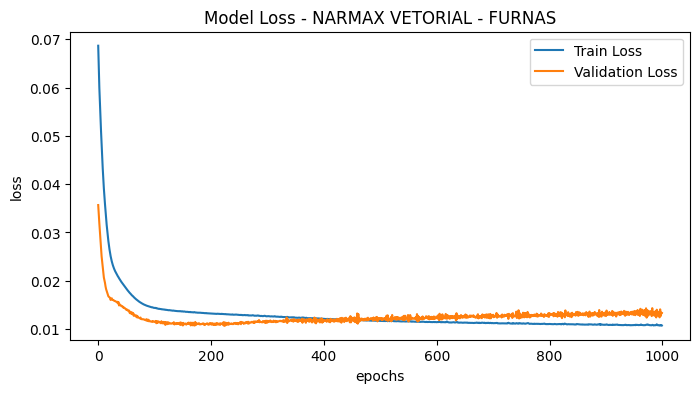

In [21]:
model_vec = NarmaxModel(look_back=12,vec_num=12)
file_path = f"../Results/Models/furnas_vec_weights_narmax_img.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0
)

history = model_vec.fit(
    vec_train[lag_list],
    vec_train[pred_list],
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(vec_validation[lag_list], vec_validation[pred_list]),
    callbacks=[model_checkpoint],
    shuffle=True
)

# Plot and save loss function from model history

method_name = 'NARMAX VETORIAL - FURNAS'
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss - {method_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig(f'{FIGURE_PATH}/model_loss_{method_name}.png', format='png')
plt.show()


In [22]:
model_vec_furnas_final = NarmaxModel(look_back=12, vec_num=12)
model_vec_furnas_final.load_weights(file_path)

df_vec = vec_furnas[[x for x in vec_furnas.columns if 'lag' not in x]].copy()


df_vec.columns = [x.replace('pred_','real_') for x in df_vec.columns]

df_vec[pred_list] = pd.DataFrame(model_vec_furnas_final.predict(vec_furnas[lag_list]),columns=pred_list)
df_vec.to_csv('../Results/NARMAX/Furnas/Vetorial/narmax_furnas_pred_2025_10_15.csv', index=False)

df_vec

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/thiago-lopes/anaconda3/envs/e-tuni-ita/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


,date,real_1,real_2,real_3,real_4,real_5,real_6,real_7,real_8,real_9,real_10,real_11,real_12,start_date,end_date,cohort,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12
0,1931-01-01,0.479595,0.476780,0.374332,0.186884,0.132001,0.120462,0.075711,0.053194,0.051787,0.089220,0.103856,0.357444,1932-01-01,1932-12-01,1. train,0.385615,0.440963,0.456564,0.317416,0.188575,0.098287,0.021327,0.036643,0.031926,0.120046,0.199211,0.271429
1,1931-02-01,0.476780,0.374332,0.186884,0.132001,0.120462,0.075711,0.053194,0.051787,0.089220,0.103856,0.357444,0.316915,1932-02-01,1933-01-01,1. train,0.433849,0.414629,0.342907,0.266479,0.175496,0.086677,0.044633,0.037547,0.097567,0.182582,0.287860,0.374082
2,1931-03-01,0.374332,0.186884,0.132001,0.120462,0.075711,0.053194,0.051787,0.089220,0.103856,0.357444,0.316915,0.146918,1932-03-01,1933-02-01,1. train,0.394067,0.326075,0.223770,0.153819,0.092552,0.044461,0.047929,0.078326,0.173581,0.260534,0.345391,0.401444
3,1931-04-01,0.186884,0.132001,0.120462,0.075711,0.053194,0.051787,0.089220,0.103856,0.357444,0.316915,0.146918,0.138475,1932-04-01,1933-03-01,1. train,0.223786,0.146567,0.083611,0.031057,0.030114,0.064517,0.119017,0.199007,0.275680,0.324069,0.325686,0.306420
4,1931-05-01,0.132001,0.120462,0.075711,0.053194,0.051787,0.089220,0.103856,0.357444,0.316915,0.146918,0.138475,0.114270,1932-05-01,1933-04-01,1. train,0.162258,0.084608,0.046867,-0.018119,-0.003032,0.073466,0.156114,0.275194,0.334911,0.374853,0.335808,0.266654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,2010-09-01,0.026457,0.071770,0.087532,0.406417,0.682240,0.287363,0.198705,0.146355,0.132564,0.150858,0.085561,0.038278,2011-09-01,2012-08-01,3. test,0.108197,0.176890,0.235453,0.401515,0.488442,0.472329,0.430362,0.286369,0.201225,0.079376,0.042051,0.058972
957,2010-10-01,0.071770,0.087532,0.406417,0.682240,0.287363,0.198705,0.146355,0.132564,0.150858,0.085561,0.038278,0.016324,2011-10-01,2012-09-01,3. test,0.119240,0.247049,0.366374,0.423565,0.436723,0.399047,0.315353,0.214794,0.097360,0.019263,-0.012102,0.016055
958,2010-11-01,0.087532,0.406417,0.682240,0.287363,0.198705,0.146355,0.132564,0.150858,0.085561,0.038278,0.016324,0.013791,2011-11-01,2012-10-01,3. test,0.253987,0.382427,0.492666,0.428525,0.353746,0.291514,0.201384,0.166714,0.062157,0.064688,0.074471,0.101269
959,2010-12-01,0.406417,0.682240,0.287363,0.198705,0.146355,0.132564,0.150858,0.085561,0.038278,0.016324,0.013791,0.065015,2011-12-01,2012-11-01,3. test,0.302494,0.369741,0.404783,0.330419,0.248618,0.172876,0.095253,0.073275,0.047923,0.087121,0.137427,0.205349


In [23]:
df_vec_pred = df_escalar[['date', 'real_norm', 'real']].copy()
all_list = []
for i in range(12):
    df_temp = df_vec.copy()
    df_temp['predicted_date'] = (df_temp['end_date'] - pd.Timedelta(weeks=4*(i))).dt.strftime('%Y-%m-01')
    df_temp['predicted_value_norm'] = df_temp[f'pred_{str(12 - i)}']
    df_temp['predicted_value'] = furnas_scaler.inverse_transform(df_temp[['predicted_value_norm']])
    df_temp['index'] = df_temp.index
    
    df_temp = df_temp[['predicted_date','predicted_value_norm','predicted_value','index']]
    all_list.append(df_temp)

all_list = pd.concat(all_list,axis=0,ignore_index=True)
all_list['date'] = pd.to_datetime(all_list['predicted_date'])
all_list['cohort'] = all_list['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))

df_vec_all = df_vec_pred.merge(all_list,on='date',how='left')
df_vec_all.to_csv('../Results/NARMAX/Furnas/Vetorial/narmax_furnas_pred_all_2025_10_15.csv', index=False)
df_vec_all


,date,real_norm,real,predicted_date,predicted_value_norm,predicted_value,index,cohort
0,1932-01-01,0.479595,1908.0,1932-01-01,0.385615,1574.091675,0,1. train
1,1932-02-01,0.476780,1898.0,1932-02-01,0.440963,1770.739990,0,1. train
2,1932-02-01,0.476780,1898.0,1932-02-01,0.433849,1745.465576,1,1. train
3,1932-03-01,0.374332,1534.0,1932-03-01,0.456564,1826.173584,0,1. train
4,1932-03-01,0.374332,1534.0,1932-03-01,0.414629,1677.176147,1,1. train
...,...,...,...,...,...,...,...,...
11527,2012-10-01,0.013791,253.0,2012-10-01,0.137427,692.276917,959,3. test
11528,2012-10-01,0.013791,253.0,2012-10-01,0.126995,655.212219,960,3. test
11529,2012-11-01,0.065015,435.0,2012-11-01,0.205349,933.604431,959,3. test
11530,2012-11-01,0.065015,435.0,2012-11-01,0.225046,1003.587708,960,3. test


In [24]:
mean_precition = df_vec_all.groupby('date').agg({'real':'mean','predicted_value':['mean','std','min','max','count']})
mean_precition.reset_index(inplace=True)
mean_precition.columns = ['date','real','mean','std','min','max','count']
mean_precition['date'] = pd.to_datetime(mean_precition['date'])
mean_precition['cohort'] = mean_precition['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))
mean_precition.to_csv('../Results/NARMAX/Furnas/Vetorial/narmax_furnas_pred_all_mean_2025_10_15.csv', index=False)

mean_precition.head(15)

,date,real,mean,std,min,max,count,cohort
0,1932-01-01,1908.0,1574.091675,NaN,1574.091675,1574.091675,1,1. train
1,1932-02-01,1898.0,1758.102783,17.871710,1745.465576,1770.739990,2,1. train
2,1932-03-01,1534.0,1702.489868,113.170395,1604.119995,1826.173584,3,1. train
3,1932-04-01,868.0,1278.945801,190.308563,999.111084,1422.349487,4,1. train
4,1932-05-01,673.0,905.823242,171.908920,724.752563,1150.801392,5,1. train
5,1932-06-01,632.0,575.257507,186.165756,314.593506,827.537659,6,1. train
6,1932-07-01,473.0,356.823578,121.374977,240.325394,532.836548,7,1. train
7,1932-08-01,393.0,299.432007,91.019615,139.622925,418.584320,8,1. train
8,1932-09-01,388.0,345.090302,71.284492,193.227707,433.229889,9,1. train
9,1932-10-01,521.0,554.312805,60.692642,465.024628,630.525024,10,1. train


In [25]:
# train = df_vec[df_vec.cohort == '1. train']
# validation = df_vec[df_vec.cohort == '2. validation']
# test = df_vec[df_vec.cohort == '3. test']

train = mean_precition[mean_precition.cohort == '1. train']
validation = mean_precition[mean_precition.cohort == '2. validation']
test = mean_precition[mean_precition.cohort == '3. test']


In [26]:
metric_df_final = pd.DataFrame(
      {
      'tipo':['Treino','Validation','Teste'],
      'MSE': [MSE(train['real'],train['mean']), MSE(validation['real'],validation['mean']), MSE(test['real'],test['mean'])],
      'MAE': [MAE(train['real'],train['mean']), MAE(validation['real'],validation['mean']), MAE(test['real'],test['mean'])],
      'MAPE': [MAPE(train['real'],train['mean']), MAPE(validation['real'],validation['mean']), MAPE(test['real'],test['mean'])],
      'R2':  [R2(train['real'],train['mean']), R2(validation['real'],validation['mean']), R2(test['real'],test['mean'])],
      }
  )
display(metric_df_final)
metric_df_final.to_csv('../Results/NARMAX/Furnas/Vetorial/narmax_furnas_metrics_2025_10_15.csv' , index=False)

,tipo,MSE,MAE,MAPE,R2
0,Treino,149726.228834,258.362938,0.300636,0.610759
1,Validation,107100.100831,245.535071,0.410027,0.510381
2,Teste,157763.299774,271.069386,0.336657,0.578457


In [27]:
df_vec_all.head()

,date,real_norm,real,predicted_date,predicted_value_norm,predicted_value,index,cohort
0,1932-01-01,0.479595,1908.0,1932-01-01,0.385615,1574.091675,0,1. train
1,1932-02-01,0.476780,1898.0,1932-02-01,0.440963,1770.739990,0,1. train
2,1932-02-01,0.476780,1898.0,1932-02-01,0.433849,1745.465576,1,1. train
3,1932-03-01,0.374332,1534.0,1932-03-01,0.456564,1826.173584,0,1. train
4,1932-03-01,0.374332,1534.0,1932-03-01,0.414629,1677.176147,1,1. train


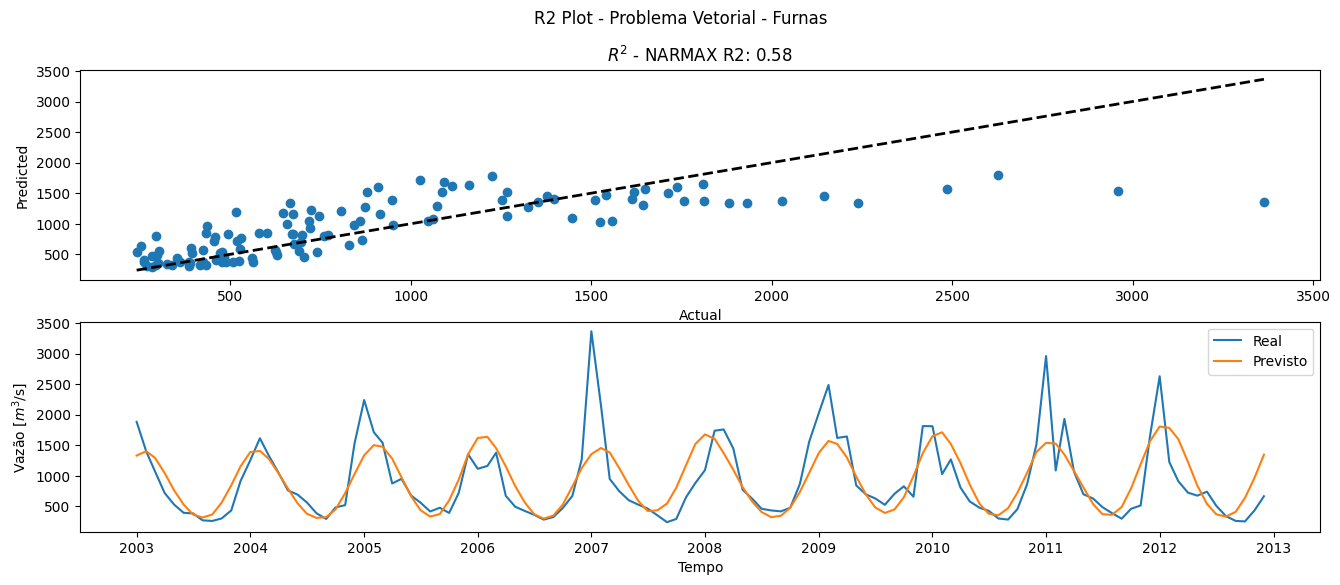

In [28]:
figure, axes = plt.subplots(2, 1, figsize=(16,6))
figure.suptitle(f'R2 Plot - Problema Vetorial - Furnas')

r2_result = metric_df_final[metric_df_final.tipo == 'Teste']['R2'].to_list()[0]
min = test['real'].min()
max = test['real'].max()
axes[0].set_title(f'$R^2$ - NARMAX R2: {r2_result:.2f}') #r2_result:.3f}')
# axes[0].scatter(test['real'], test['mean'])
axes[0].scatter(test['real'], test['mean'])
axes[0].plot([min, max], [min, max], 'k--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')


sns.lineplot(ax = axes[1], data=test,x='date',y='real', label='Real')
sns.lineplot(ax = axes[1], data=test,x='date',y='mean', label='Previsto')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Vazão [$m^3$/s]')

plt.savefig(f'../Figure/Results/narmax_vec_furnas_r2_2025_10_15.png', format='png')


plt.show()

In [29]:
sample = 100

metrics_list = []
for s in range(sample):
    model_temp = NarmaxModel(look_back=12,vec_num=12)

    file_path = f"../Results/Models/furnas_vec_weights_narmax_sample_{i}.weights.h5"

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=file_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0
    )

    model_temp.fit(
        vec_train[lag_list],
        vec_train[pred_list],
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        validation_data=(vec_validation[lag_list], vec_validation[pred_list]),
        callbacks=[model_checkpoint],
        shuffle=True
    )

    # model_vec_furnas = NarmaxModel(look_back=12, vec_num=12)
    # model_vec_furnas.load_weights(file_path)
    furnas_scaler = joblib.load('../Results/Models/Furnas_scaler.pkl')

    df_vec = vec_furnas[[x for x in vec_furnas.columns if 'lag' not in x]].copy()
    df_vec.columns = [x.replace('pred_','real_') for x in df_vec.columns]
    df_vec[pred_list] = pd.DataFrame(model_temp.predict(vec_furnas[lag_list]),columns=pred_list)
    df_vec['sample'] = s

    print(s)
    df_vec.to_csv(f'../Results/NARMAX/Furnas/Vetorial/Samples/narmax_furnas_pred_sample_{s}.csv', index=False)

    df_vec_pred = df_escalar[['date', 'real_norm', 'real']].copy()
    all_list = []
    for i in range(12):
        df_temp = df_vec.copy()
        df_temp['predicted_date'] = (df_temp['end_date'] - pd.Timedelta(weeks=4*(i))).dt.strftime('%Y-%m-01')
        df_temp['predicted_value_norm'] = df_temp[f'pred_{str(12 - i)}']
        df_temp['predicted_value'] = furnas_scaler.inverse_transform(df_temp[['predicted_value_norm']])
        df_temp['index'] = df_temp.index
        
        df_temp = df_temp[['predicted_date','predicted_value_norm','predicted_value','index']]
        all_list.append(df_temp)

    all_list = pd.concat(all_list,axis=0,ignore_index=True)
    all_list['date'] = pd.to_datetime(all_list['predicted_date'])
    all_list['cohort'] = all_list['date'].apply(lambda x: cohort_type(x,model_type='vetorial'))
    all_list['sample'] = s

    df_vec_all = df_vec_pred.merge(all_list,on='date',how='left')
    df_vec_all.to_csv(f'../Results/NARMAX/Furnas/Vetorial/Samples/narmax_furnas_pred_all_sample_{s}.csv', index=False)

    



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
0
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
12
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
14
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
17
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
18
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
21
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
22
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23
31

In [31]:
all_results = pd.concat([model_performance_vec(pd.read_csv(f'../Results/NARMAX/Furnas/Vetorial/Samples/narmax_furnas_pred_all_sample_{i}.csv')) for i in range(sample)]).reset_index(drop=True)
all_results.to_csv(f'../Results/NARMAX/Furnas/Vetorial/Samples/all_results.csv', index=False)
all_results



,sample,tipo,MSE,MAE,MAPE,R2
0,0.0,Treino,113675.934384,217.196333,0.245979,0.704479
1,0.0,Validation,92412.061204,221.379753,0.355915,0.577529
2,0.0,Teste,149111.201213,253.028647,0.310207,0.601576
3,1.0,Treino,112413.948425,220.050054,0.255422,0.707759
4,1.0,Validation,103096.445661,247.953584,0.409983,0.528684
...,...,...,...,...,...,...
295,98.0,Validation,101761.032423,236.138508,0.392438,0.534789
296,98.0,Teste,161239.314108,267.302402,0.338678,0.569169
297,99.0,Treino,166121.987938,283.559318,0.358552,0.568136
298,99.0,Validation,131231.116022,301.784847,0.574103,0.400063


In [32]:
# plt.savefig(f'../Figure/Results/narmax_camargos_r2_2025_10_08.png', format='png')


plt.show()